# Conditional VAE
Train a conditional VAE on the MNIST handwritten digit dataset. 

This makes use of: our custom Keras model class defined in vaegan.vae.py, our
class for loading the MNIST dataset defined in vaegan.data, and our custom Keras
callback in vaegan.callbacks.

A directory called 'output' will be created to save figures and the trained
model. 



In [1]:
nEpochs=20  # orig, longer training
#nEpochs=3  # quick testing during development

## 1. Import 3rd party libraries

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload


2025-05-28 12:45:50.049500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748454350.073994   44276 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748454350.081555   44276 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748454350.100828   44276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748454350.100846   44276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748454350.100849   44276 computation_placer.cc:177] computation placer alr

## 2. Import our own classes (that we will complete together)

In [3]:
# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import SaveImagesConditional
import vaegan.vae

## 3. Show some our data

I0000 00:00:1748454354.702778   44276 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15506 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0
/project/nanocourse/SWE_OOP/train11/Module_2_Materials/04_ExerciseCodeAndInstructions/vaegan/vaegan/data.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


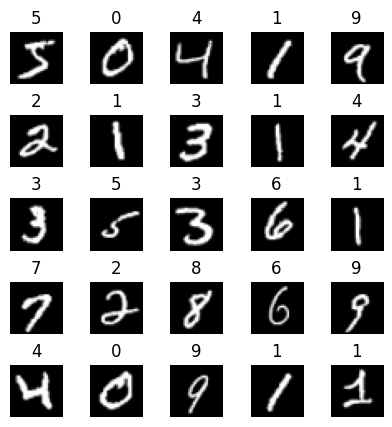

In [4]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist_cvae'
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [5]:
pyModule = reload(vaegan.vae)
    
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
model = pyModule.ConditionalVAE(n_classes=n_classes,kl_loss_weight=2.,)

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.
model.compute_output_shape([(1, 32, 32, 1), (1, n_classes)])
model.decoder.compute_output_shape((1, 18))

Loaded version: vaegan.vae
Loaded version: vaegan.vae


TensorShape([1, 32, 32, 1])

## <span style="color:blue"> Correct model dimensions </span>
    

<span style="color:blue"> === OVERALL MODEL ==== </span>

```
Layer (type)                 Output Shape              Param #   
=================================================================
encoder (Encoder)            multiple                  243456    
_________________________________________________________________
decoder (Decoder)            multiple                  192385    
_________________________________________________________________
recon_loss (Mean)            multiple                  2         
_________________________________________________________________
kl_loss (Mean)               multiple                  2         
_________________________________________________________________
total_loss (Mean)            multiple                  2         
=================================================================
Total params: 435,847
Trainable params: 435,137
Non-trainable params: 710
__________________________

```
<span style="color:blue"> === ENCODER SUBMODEL ====</span>
```
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_4 (InputLayer)            [(None, 32, 32, 11)] 0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 16)   2832        input_4[0][0]                    
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 32, 32, 16)   64          conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 32, 32, 16)   0           bn0[0][0]                        
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 32)   8224        relu0[0][0]                      
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 16, 16, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
relu1 (ReLU)                    (None, 16, 16, 32)   0           bn1[0][0]                        
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 8, 8, 64)     32832       relu1[0][0]                      
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, 8, 8, 64)     256         conv2[0][0]                      
__________________________________________________________________________________________________
relu2 (ReLU)                    (None, 8, 8, 64)     0           bn2[0][0]                        
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 4, 4, 64)     65600       relu2[0][0]                      
__________________________________________________________________________________________________
bn3 (BatchNormalization)        (None, 4, 4, 64)     256         conv3[0][0]                      
__________________________________________________________________________________________________
relu3 (ReLU)                    (None, 4, 4, 64)     0           bn3[0][0]                        
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1024)         0           relu3[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          131200      flatten[0][0]                    
__________________________________________________________________________________________________
dense_mean (Dense)              (None, 8)            1032        dense[0][0]                      
__________________________________________________________________________________________________
dense_logvar (Dense)            (None, 8)            1032        dense[0][0]                      
==================================================================================================
Total params: 243,456
Trainable params: 243,104
Non-trainable params: 352

```
<span style="color:blue"> === DECODER SUBMODEL ====</span>
```
Layer (type)                 Output Shape              Param #   
=================================================================
input_2 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              19456     
_________________________________________________________________
relu_dense (ReLU)            (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
tconv0 (Conv2DTranspose)     (None, 8, 8, 64)          65600     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 8, 8, 64)          256       
_________________________________________________________________
relu0 (ReLU)                 (None, 8, 8, 64)          0         
_________________________________________________________________
tconv1 (Conv2DTranspose)     (None, 16, 16, 64)        65600     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
relu1 (ReLU)                 (None, 16, 16, 64)        0         
_________________________________________________________________
tconv2 (Conv2DTranspose)     (None, 32, 32, 32)        32800     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
relu2 (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
tconv3 (Conv2DTranspose)     (None, 32, 32, 16)        8208      
_________________________________________________________________
bn3 (BatchNormalization)     (None, 32, 32, 16)        64        
_________________________________________________________________
relu3 (ReLU)                 (None, 32, 32, 16)        0         
_________________________________________________________________
conv_out (Conv2D)            (None, 32, 32, 1)         17        
_________________________________________________________________
sigmoid_out (Activation)     (None, 32, 32, 1)         0         
=================================================================
Total params: 192,385
Trainable params: 192,033
Non-trainable params: 352

```
## 5. Now check your model's  dimensions against this list above

In [6]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== ENCODER SUBMODEL ====")
enc_in = tf.keras.layers.Input((32,32,11)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
enc_out  = model.encoder.call(enc_in) 
enc = tf.keras.Model(enc_in, enc_out) 
enc.summary()
print("=== DECODER SUBMODEL ====")
dec_in = tf.keras.layers.Input(model.n_latent_dims+10) 
dec_out  = model.decoder.call(dec_in) 
dec = tf.keras.Model(dec_in, dec_out) 
dec.summary()




=== OVERALL MODEL ====
Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  243456    
                                                                 
 decoder (Decoder)           (1, 32, 32, 1)            192385    
                                                                 
Total params: 435847 (1.66 MB)
Trainable params: 435137 (1.66 MB)
Non-trainable params: 710 (2.77 KB)
_________________________________________________________________
=== ENCODER SUBMODEL ====
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 11)]         0         []                            
                                                             

## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                             model=model,
                                             example_images=data.images_train[:10],
                                             example_labels=labels_onehot[:10],
                                             n_generated_images=10,
                                             n_latent_dims=model.n_latent_dims)

## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=1,
                 callbacks=[save_images_callback])

I0000 00:00:1748454360.656696   44559 cuda_dnn.cc:529] Loaded cuDNN version 90300


469/469 [==============================] - 14s 22ms/step - recon_loss: 40.3128 - kl_loss: 3.0884 - total_loss: 46.4895


In [9]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== ENCODER SUBMODEL ====")
model.encoder.summary()
print("=== DECODER SUBMODEL ====")
model.decoder.summary()

=== OVERALL MODEL ====
Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  243456    
                                                                 
 decoder (Decoder)           (1, 32, 32, 1)            192385    
                                                                 
Total params: 435847 (1.66 MB)
Trainable params: 435137 (1.66 MB)
Non-trainable params: 710 (2.77 KB)
_________________________________________________________________
=== ENCODER SUBMODEL ====
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 32, 32, 16)        2832      
                                                                 
 bn0 (BatchNormalization)    (None, 32, 32, 16)        64        
                          

In [10]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/20
469/469 [==============================] - 10s 20ms/step - recon_loss: 26.7618 - kl_loss: 4.7407 - total_loss: 36.2432
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 24.5704 - kl_loss: 5.1175 - total_loss: 34.8054
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 23.5446 - kl_loss: 5.2904 - total_loss: 34.1253
Epoch 4/20
469/469 [==============================] - 9s 20ms/step - recon_loss: 22.9092 - kl_loss: 5.3866 - total_loss: 33.6823
Epoch 5/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 22.4713 - kl_loss: 5.4783 - total_loss: 33.4278
Epoch 6/20
469/469 [==============================] - 9s 20ms/step - recon_loss: 22.1528 - kl_loss: 5.5280 - total_loss: 33.2087
Epoch 7/20
469/469 [==============================] - 10s 21ms/step - recon_loss: 21.8592 - kl_loss: 5.5740 - total_loss: 33.0071
Epoch 8/20
469/469 [==============================] - 9s 20ms/step - recon_loss: 21.6755 - k

## 8. Training saves results to disk, now also plot training curves

/tmp/ipykernel_44276/622263360.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


INFO:tensorflow:Assets written to: ./outputs/mnist_cvae/cvae/assets


INFO:tensorflow:Assets written to: ./outputs/mnist_cvae/cvae/assets


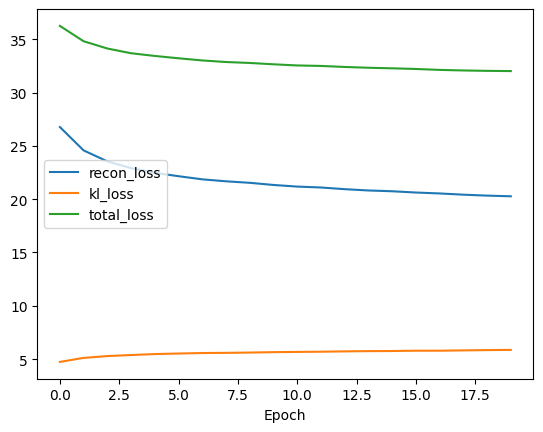

In [11]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['recon_loss', 'kl_loss', 'total_loss']:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)
    
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
fig.show()

# Save the model 
model.save(os.path.join(output_dir, 'cvae'))